## spatial-temporal dynamics

In [6]:
# imports

import numpy as np
import pandas as pd
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
# from matplotlib.animation import FuncAnimation
import itertools
import random
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.d03_processing.BlinkProcessor import BlinkProcessor
from src.d03_processing.fixations.SignalProcessor import SignalProcessor
from src.d03_processing.fixations.I_VDT import I_VDT
from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d03_processing.aoi import collision_sphere_radius
from src.d03_processing.feature_extract.to_viewing import to_viewing
from src.d03_processing.fixations.FixAlgos import *
from src.d03_processing.feature_calculate.viewing_compare_calcs import ea_td

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.linalg import orthogonal_procrustes
from scipy.spatial.distance import cdist
from scipy.spatial import procrustes
from src.d04_wrangling.add_ppt_info import get_ppts_by_group

In [45]:
def get_center(obj, tps, y_adjust=0,  trial=None, preshift_postshift=None):
    # display(tps.iloc[:2, :].style)
    in_trial = False
    center = None
    if trial is not None:
        for i in range(1, 5):
            col = f"obj{i}_name"
            if trial[col].to_numpy()[0] == obj:
                center = (trial[f"obj{i}_{preshift_postshift}_x"][0],
                          trial[f"obj{i}_{preshift_postshift}_z"][0],
                          0.7 + y_adjust)
                in_trial = True
    if in_trial is False:
        row = tps[tps.gaze_object == obj].reset_index(drop=True).iloc[0, :]
        center = (row.object_position_x, row.object_position_z, row.object_position_y + y_adjust)

    # print(f"{obj}: {row.gaze_object} {center}")
    return center

def plot_3d_probability_distribution(probability_map, voxel_centers, threshold=0.00001, ax=None, heatmap_translate=[0, 0, 0], alpha_scale=0.2):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # set axes
        ax.set_xlim([-0.5, 0.5])
        ax.set_zlim([-0.5, 0.5])
        ax.set_ylim([-0.5, 0.5])

        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')
        ax.set_title('3D Probability Distribution')

    # Extract x, y, z coordinates and probabilities
    x, y, z = voxel_centers[:, 0], voxel_centers[:, 1], voxel_centers[:, 2]
    x += heatmap_translate[0]
    y += heatmap_translate[1]
    z += heatmap_translate[2]
    prob = probability_map.flatten()
    idx = np.where(prob > threshold)[0]
    x, y, z = x[idx], y[idx], z[idx]
    prob = prob[idx]
    
    # Normalize probability values to the range [0,1] for use as alpha values
    p_norm = (prob - prob.min()) / (prob.max() - prob.min())

    # Scale alpha values by the alpha_scale parameter
    alpha = p_norm * alpha_scale
    
    # Create the colormap with the specified alpha scaling
    
    # Set color map and scale for probability
    # cmap options: jet, rainbow, OrRd, YlOrRd
    cmap = plt.cm.get_cmap('OrRd')
    colors = cmap(p_norm)
    colors[:, -1] *= alpha_scale * p_norm
    norm = plt.Normalize(vmin=np.min(prob), vmax=np.max(prob))
    # print('min: ', np.min(prob), 'max: ', np.max(prob))

    # Create scatter plot
    # ax.scatter(x, z, y, c=prob, cmap=cmap, norm=norm, alpha=0.2)
    ax.scatter(x, z, y, c=colors)

    # Add color bar
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(prob)
    plt.colorbar(mappable)

    # Show plot
    plt.show()
    
def viewing_plot(tps, array_objects=None, gp_lab='table', gp_line=False, ax=None, alpha=0.5, trial=None, preshift_postshift=None,
                 prob_map=None, pmap_voxel_centers=None):
    viewing_id = tps.reset_index(drop=True).viewing_id[0]

    if trial is not None:
        trial = trial.reset_index(drop=True)

    if array_objects is None:
        full_objects = np.unique(tps.gaze_object)
        if trial is not None:
            for i in range(1, 5):
                col = f"obj{i}_name"
                obj = trial[col][0]
                if obj not in full_objects:
                    full_objects = np.append(full_objects, obj)
        # array_objects = TaskObjects.array_and_invisible
        table_objects = ['InvisibleObject', *TaskObjects.array_objects]
        array_objects = full_objects[np.isin(full_objects,np.array(table_objects))]



        # print(array_objects)

    if ax is None:
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(projection='3d')

    camera_pos = np.array([np.nanmean(tps.camera_x), np.nanmean(tps.camera_z), np.nanmean(tps.camera_y)])

    # plot gaze points as points, unless heatmap
    if prob_map is None:
        x, y, z = tps.gaze_collision_x.to_numpy(),tps.gaze_collision_y.to_numpy(),tps.gaze_collision_z.to_numpy()
        lab = tps.gaze_object == 'Table' if gp_lab=='table' else np.array(tps[gp_lab].to_numpy(), dtype=bool)
        no_lab = np.invert(lab)
        # print(lab)
        # print(no_lab)
        ax.scatter(x[lab], z[lab], y[lab], c='red', s=2, alpha=1)
        ax.scatter(x[no_lab], z[no_lab], y[no_lab], c='g', s=2, alpha=alpha)
        if gp_line:
            ax.plot(x, z, y, c='k', linewidth=0.4, alpha=alpha)

    # draw a cylinder to represent a table
    table_y_scale =  0.06538646
    table_center =  get_center('Table', tps) # center of the cylinder
    camera_vec = table_center - camera_pos
    # print(f"table: {table_center}")
    radius = 0.55  # radius of the cylinder
    height = table_y_scale * 2  # height of the cylinder
    resolution = 20

    # Create the cylinder mesh
    z = np.linspace(table_center[2]-height/2, table_center[2]+height/2, resolution)
    theta = np.linspace(0, 2*np.pi, resolution)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + table_center[0]
    y_grid = radius*np.sin(theta_grid) + table_center[1]

    # Create the Poly3DCollection
    verts = []
    for i in range(len(z)-1):
        verts += [list(zip(x_grid[i], y_grid[i], z_grid[i])),
                  list(zip(x_grid[i+1], y_grid[i+1], z_grid[i+1])),
                  list(zip(x_grid[i+1], y_grid[i+1], z_grid[i])),
                  list(zip(x_grid[i], y_grid[i], z_grid[i+1]))]
    table = Poly3DCollection(verts, facecolors=[1, 1, 1, 0], edgecolors=[0, 0, 0, 0.2], alpha=0.0)
    table.set_zsort('min')
    ax.add_collection3d(table)

    for obj in array_objects:
        sphere_center = get_center(obj, tps, trial=trial, preshift_postshift=preshift_postshift)
        sphere_radius = 0.12 if obj == 'InvisibleObject' else collision_sphere_radius(sphere_center, camera_pos)
        sphere_center = get_center(obj, tps, y_adjust=sphere_radius, trial=trial, preshift_postshift=preshift_postshift)
        # print(f"{obj}: {sphere_center}")
        # sphere_center = get_center(obj, tps)
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 30)
        x = sphere_radius * np.outer(np.cos(u), np.sin(v)) + sphere_center[0]
        y = sphere_radius * np.outer(np.sin(u), np.sin(v)) + sphere_center[1]
        z = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v)) + sphere_center[2]
        c = [0, 0.8, 0.8, 0.5] if obj == 'InvisibleObject' else [0, 0, 1, 0.5]
        sphere = ax.plot_surface(x, y, z, color=c, alpha=0.05)
        sphere.set_edgecolor(c)
    


    # set axis limits and labels
    ax_len = 0.55
    ax.set_xlim([table_center[0]-ax_len, table_center[0]+ax_len])
    ax.set_ylim([table_center[1]-ax_len, table_center[1]+ax_len])
    ax.set_zlim([table_center[2]-ax_len, table_center[2]+ax_len])
    ax.grid(False)
    ax.set_title(f'3D model of {viewing_id} viewing')

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_axis_off()

    # set view by average camera position
    azimuthal_angle = 180 + (np.arctan2(camera_vec[1], camera_vec[0]) * 180 / np.pi)
    polar_angle = 180 - (np.arccos(camera_vec[2] / np.linalg.norm(camera_vec)) * 180 / np.pi)
    # Convert angles to radians
    azimuthal_angle_rad = np.deg2rad(azimuthal_angle)
    polar_angle_rad = np.deg2rad(polar_angle)
    # print(f'elev: {polar_angle}, azim: {azimuthal_angle}')
    ax.view_init(elev=polar_angle, azim=azimuthal_angle)

    # add probability map
    if prob_map is not None:
        plot_3d_probability_distribution(prob_map, pmap_voxel_centers,
                                         heatmap_translate=[table_center[0], 0.7, table_center[1]],
                                         ax=ax)





# def object_viewing_plot(tps, trial):


In [89]:
# data - 1 ppt first
# get data
pids_dict = get_ppts_by_group()
young_pids = pids_dict['Younger']
old_pids = pids_dict['Older']
mci_pids = pids_dict['MCI+']
cutoff = 7000   # ms
pid_groups = [young_pids, old_pids, mci_pids]
group_data = []
group_names = ['Younger', 'Older', 'MCI+']
group_codes = ['y', 'o', 'p']
group_colours = ['r', 'g', 'm']
master_dict = {}
axes = []
configurations = [1]
upsample = 1  # ms
downsample = 15  #ms
max_config_views = 4  # this will force different viewpoints to be combined if less than 4 or 5, must be 2 or more for kmeans
# define signal columns
sig_cols = ('gaze_collision_x', 'gaze_collision_y', 'gaze_collision_z')

dataframe returned in 0.029918909072875977
dataframe returned in 0.027925729751586914
dataframe returned in 0.031914710998535156
dataframe returned in 0.0285491943359375
dataframe returned in 0.02892303466796875
dataframe returned in 0.027950286865234375
dataframe returned in 0.030916929244995117
dataframe returned in 0.027926921844482422
dataframe returned in 0.028922557830810547
dataframe returned in 0.028354167938232422
dataframe returned in 0.02792501449584961
dataframe returned in 0.027925491333007812
dataframe returned in 0.026927709579467773
dataframe returned in 0.026927947998046875
dataframe returned in 0.027925729751586914
dataframe returned in 0.018949508666992188
dataframe returned in 0.02892279624938965
dataframe returned in 0.02792644500732422
dataframe returned in 0.027925491333007812
dataframe returned in 0.028922557830810547
dataframe returned in 0.02792501449584961
dataframe returned in 0.02892303466796875
dataframe returned in 0.01894998550415039
dataframe returned i

C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


n_outliers 10
final number of clusters 4


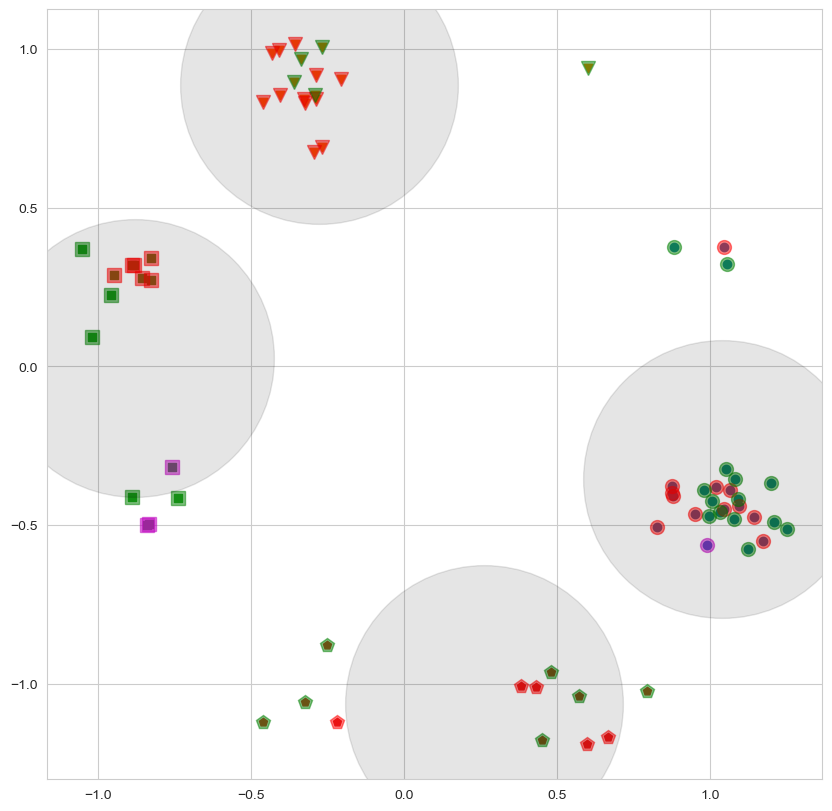

In [98]:
all_pids = []
# for each group
for g in range(len(pid_groups)):
    # add participants to unravelled list
    all_pids.extend(pid_groups[g])
pids = list(all_pids)
final_pids = pids.copy()
# all trials for all pids
all_trials = fetch_trials(all_pids.copy())

# for each configuration of objects
for j, config in enumerate(configurations):
    config_code = str(config) # string
    t = np.arange(0, cutoff, downsample)  # time array
    tens = None  # predefine tensor variable of gaze-time points for participant gaze looping
    Ts = []  # predefine variable for saving gaze-time points for clustered gaze data
    config_table_pos = []   # predefine variable for saving table positions
    cluster_pids = []    # for saving pids organised by cluster
    object_distance_mean_x, object_distance_mean_z = [], []   # for categorisation configuration views
    mean_camera_pos = []    # used for clustering views

    # predefine data lists
    Ts_normed = []  # for saving normalised gaze data
    camera_views=[] # for saving camera views per configuration
    Ms = None #  not sure
    # for each group
    for g in range(len(pid_groups)):

        pids = pid_groups[g]

        # n pids in the group
        n_pids = len(pids)

        # for each participant in this group
        for i in range(n_pids):
            # print(i, n_pids, pids)
            pid = pids[i]

            # get pid group for master dict
            for g in range(len(pid_groups)):
                if pid in pid_groups[g]:
                    group_code = group_codes[g]
                    break

            # fetch data
            tps = fetch_timepoints(pid, ret_epochs=['na'], viewing_type='enc', configurations = [config], suppress_print=True)
            try:
                trial = all_trials[all_trials.trial_id == tps.trial_id[0]].reset_index(drop=True)
            except (IndexError, KeyError) as e:
                # print(pid)
                # print(final_pids)
                final_pids.remove(pid)
                # n_pids -= 1
                continue

            # participant's viewpoint
            camera_pos = np.array([np.nanmean(tps.camera_x),
                                   np.nanmean(tps.camera_y),
                                   np.nanmean(tps.camera_z)])
            mean_camera_pos.append(camera_pos)

            # table position for zero adjustment
            table_x, table_z  = trial.table_location_x[0], trial.table_location_z[0]
            config_table_pos.append((table_x, table_z))

            # object distances for categorising configuration views
            object_distance_xs, object_distance_zs = [], []
            for o in range(1, 5):
                col = f"obj{o}_preshift"
                x_dist = trial[f"{col}_x"][0] - camera_pos[0]
                # print(x_dist)
                object_distance_xs.append(x_dist)
                object_distance_zs.append(trial[f"{col}_z"][0] - camera_pos[2])
            # print(np.mean(object_distance_xs))
            object_distance_mean_x.append(np.mean(object_distance_xs))
            object_distance_mean_z.append(np.mean(object_distance_zs))

            # None check
            if tps is None or len(tps) < 2:
                print(f"no timepoints")
                continue

            # signal preprocessing steps
            s_tps = SignalProcessor.sandwiched_gp_filter(tps.copy(deep=True))
            b_tps = BlinkProcessor(s_tps.copy(deep=True), max_blink_duration=1000, d_impute_threshold=0.16, impute_buffer_duration=8).timepoints
            if b_tps is None:
                print(f" invalid")
                continue
            f_tps = SignalProcessor.filter_timepoints(b_tps.copy(deep=True), downsample_to=downsample)

            # upsample to 1ms and make all viewings the same length defined by cutoff
            xyz = None
            for col in sig_cols:
                up = SignalProcessor(f_tps[col].to_numpy(), f_tps.eye_timestamp_ms.to_numpy()).upsample_1d(1)      # signal processor class instance with signal and time
                up = up[:cutoff]
                if len(up) < cutoff:
                    nans = np.empty(cutoff-len(up))
                    up = np.append(up, nans.fill(np.nan))
                down = up[::downsample].reshape(-1, 1)

                # # adjust for table position differences
                # if col == 'gaze_collision_x':
                #     down -= table_x
                # elif col == 'gaze_collision_z':
                #     down -= table_z

                # concatenate 3d gaze points
                xyz = down if xyz is None else np.concatenate((xyz, down), axis=1)


            # concatenate 4d gaze-time points
            xyz = np.reshape(xyz, (len(xyz), 3, 1))
            tens = xyz if tens is None else np.concatenate((tens, xyz), axis=2)

    # # CLUSTERING CONFIGURATION VIEWS

    # use mean distance from objects and k-means clustering to identify the two different views of each arrangement
    # format data
    X = np.concatenate((np.array(object_distance_mean_x).reshape(-1, 1), np.array(object_distance_mean_z).reshape(-1, 1)), axis=1)
    # print(X.shape)

    # print(X)

    # get labels and assign as clusters
    final_pids = np.array(final_pids)
    max_clusters = max_config_views
    # Set a threshold for outlier detection
    threshold = 0.5
    # sil = np.zeros([max_clusters])
    range_clusters = range(2, max_clusters+1)
    for n_clust in range_clusters:
        kmeans = KMeans(n_clusters=n_clust,  random_state=0, n_init=5).fit(X)
        # kmeans = KMeans(n_clusters=n_clust, random_state=0, n_init=5).fit(data_tenth)

        # Calculate the distances of each point to its nearest cluster centroid
        distances = cdist(X, kmeans.cluster_centers_, 'euclidean')
        min_distances = np.min(distances, axis=1)
        # Identify outliers as data points with distances above the threshold
        outliers = X[min_distances > threshold]
        print('n_outliers', len(outliers))
        if len(outliers) > 0:
            continue
        else:
            break

        # silh = silhouette_score(X, kmeans.labels_)
        # sil[n_clust-1] = np.mean(silh)
    # print(sil)
    n_clusters = n_clust
    print('final number of clusters', n_clusters)
    cluster_labs = np.array(kmeans.labels_, dtype=int)
    markers = ['o', 'v', 's', 'p']  # define as many markers as you have clusters

    ax = plt.figure(figsize=(10, 10)).add_subplot()
    for px in range(len(final_pids)):
        for gx, group_pids in enumerate(pid_groups):
            if final_pids[px] in group_pids:
                colour = group_colours[gx]
        marker =  markers[cluster_labs[px]]
        ax.plot(X[px,0], X[px, 1], marker, c=colour, markersize=10, alpha=0.5)
    # plot the centroids


    # Assuming X is two-dimensional
    for i in np.unique(cluster_labs):
        ax.scatter(X[cluster_labs == i, 0], X[cluster_labs == i, 1], marker=markers[i], label=f"Cluster {i}")

    ax.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 'ok', markersize=200, alpha=0.1)
    plt.show()

    # print('labels', cluster_labs)
    cluster_idxs = []
    for i in range(n_clusters):
        cluster_idx = cluster_labs == i
        # print(f'{i} clusters', cluster_idx)
        cluster_idxs.append(cluster_idx)
        cluster_pids.append(final_pids[cluster_idx])
        tensor_clust = tens[:, :, cluster_idx]
        Ts.append(tensor_clust)

    ## SPLIT CELL HERE - THE ABOVE SHOULD GO THROUGH ALL PARTICIPANT DATA (REGARDLESS OF GROUP) AND CLUSTER THE DIFFERENT VIEWS, SAVING THE VIEW PER PARTICIPANT
    ## THE BELOW SHOULD THEN LOOP BACK THROUGH THE (SAVED, PROCESSED TIMEPOINTS) TO NORMALISE AND ORGANISE DATA BY VIEW
    ## TRY TO ORGANISE INTO A DATAFRAME: t, x, y, z, pid, group, config, config_view

    # # FUNCTION FOR NORMALISING WITHIN VIEWS
    # define function to convert for each cluster/view
    def view_to_3d(camera_view, tensor, table_positions):
        table_2ds = []
        zero_2ds = []
        xy_full = None
        refs_1 = None
        points_1 = None
        view_ys = []

        for i in range(tensor.shape[2]):
            point_matrix = np.copy(tensor[:, :, i]).reshape(-1, 3)
            view = camera_view[i, :]
            view_ref = np.array([view[0], 0, view[2]]).T
            view_ys.append(view[1])

            table_3d = np.array([table_positions[i][0], 0.7, table_positions[i][1]]).T

            v = table_3d - view
            norm = v / np.linalg.norm(v)

            # Perform Procrustes analysis to find the optimal transformation that aligns the two views
            refs = np.stack((table_3d, view_ref), axis=1).T
            if i == 0:
                refs_1 = np.copy(refs)
                refs_1_copy = np.array(refs_1)
                point_matrix = np.array(point_matrix.T, copy=True)
                points_copy = np.array(point_matrix, copy=True)

                # translate data to origin
                point_matrix -= refs_1[0, :].reshape(-1, 1)
                refs_1 -= refs_1[0, :]   # zero on tabletop centre
                view_ys[i] -= refs_1[0, 1]
                refs_1_meaned = np.array(refs_1)

                # change scaling of data (in rows) such that trace(mtx*mtx') = 1
                norm_1 = np.linalg.norm(refs_1)
                # print("norm 1" ,norm_1)
                refs_1 /= norm_1
                refs1_normed = np.array(refs_1)
                # point_matrix /= norm_1
                # print("refs 1 after norm divide:", refs_1)
                # print("point_matrix after norm divide:", point_matrix)

                points_1 = np.array(point_matrix, copy=True)



            else:
                # the following taken from scipy procrustes function
                # translate all the data to the origin
                refs2_copy = np.array(refs)
                point_matrix = point_matrix.T

                point_matrix -= refs[0, :].reshape(-1, 1)

                refs -= refs[0, :]
                # print('refs post zero', refs)
                view_ys[i] -= refs[0, 1]
                refs2_meaned = np.array(refs)

                # point_matrix -= np.mean(point_matrix, 0)
                norm_2 = np.linalg.norm(refs)
                # change scaling of data (in rows) such that trace(mtx*mtx') = 1
                refs /= norm_2
                refs2_normed  = np.array(refs)
                # point_matrix /= norm_2

                if norm_1 == 0 or norm_2 == 0:
                    raise ValueError("Input matrices must contain >1 unique points")

                # get transformation of second matrix to minimize disparity
                R, s = orthogonal_procrustes(refs_1, refs)

                # print(R)
                y_fix = np.array([0, 1, 0])
                z_fix = np.array([0, 0, 1])

                refs_trans = np.dot(refs, R.T) #* s

                points_pre_transform = np.copy(point_matrix)



            point_matrix = np.copy(point_matrix).T   # transpose back
            tensor[:, :, i] = point_matrix  # overwrite
        return tensor


    # add to overall array
    # convert to numpy for cluster indexing
    mean_camera_pos = np.array(mean_camera_pos).reshape(-1, 3)

    # Ms = xy_1 if Ms is None else np.concatenate((Ms, xy_1), axis=3)
    # Ms = np.concatenate((Ms, xy_2), axis=3)
    for i in range(len(Ts)):
        # print(mean_camera_pos[cluster])
        cluster = cluster_idxs[i]
        camera_view = mean_camera_pos[cluster, :]
        # print(mean_view)
        config_table_pos = np.array(config_table_pos)
        # print('cluster', cluster)
        # print('table_positions', table_positions)
        table_positions = config_table_pos[cluster]
        tensor_1 = view_to_3d(camera_view, np.copy(Ts[i]), table_positions)
        camera_views.append(camera_view)
        Ts_normed.append(tensor_1)

    
    
# print(Ms.shape)

In [40]:
all_trials = fetch_trials(all_pids.copy())
# final_pids

(467, 3, 27)


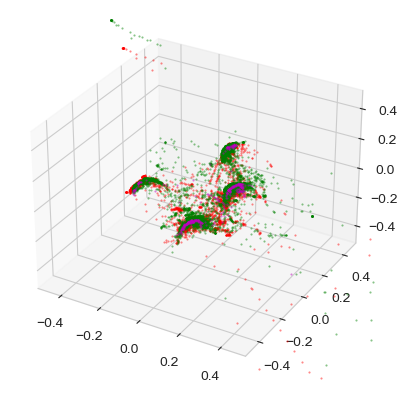

(467, 3, 17)


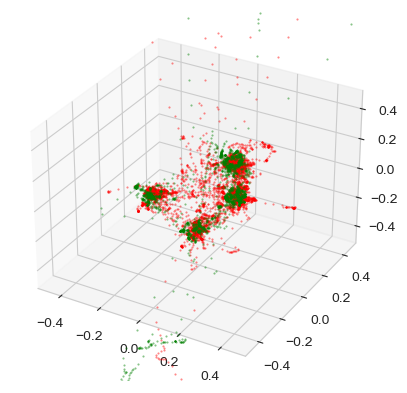

(467, 3, 14)


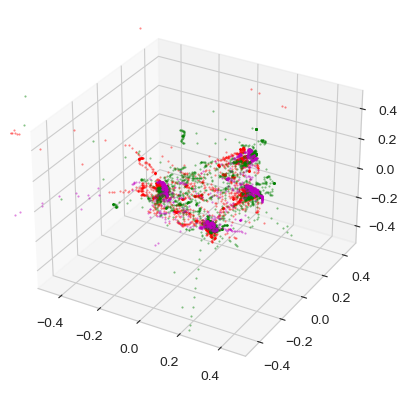

(467, 3, 12)


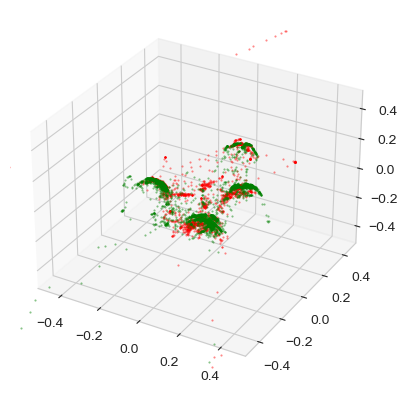

In [30]:
colors = itertools.cycle(["r", "b", "g", "c", "m", "k"])
group_colors = ['r', 'g', 'm']
for t in range(len(Ts_normed)):
    ax = plt.figure().add_subplot(projection='3d')
    # print(Ts_normed)
    tensor = Ts_normed[t]

    print(tensor.shape)
    for i in range(tensor.shape[2]):
        # print(i)
        # color = next(colors)
        for g, pids in enumerate(pid_groups):
            if cluster_pids[t][i] in pids:
                color = group_colors[g]
        # print(color)
        x = tensor[:, 0, i].flatten()
        y = tensor[:, 2, i].flatten()
        z = tensor[:, 1, i].flatten()
        # print(x)

        ax.plot(x, y, z, '.', c=color, alpha=0.5, markersize=1)

    ax.set_xlim([-0.5, 0.5])
    ax.set_zlim([-0.5, 0.5])
    ax.set_ylim([-0.5, 0.5])
    plt.show()


In [7]:

# colors = itertools.cycle(["r", "b", "g", "c", "m", "k"])
# for t in range(Ms.shape[-1]):
#     ax = plt.figure().add_subplot()
#     tensor = Ms[:,:,:,t]
    
#     for i in range(tensor.shape[2]):
#         print(i)
#         color = next(colors)
#         print(color)
#         x = tensor[:, 0, i]
#         y = tensor[:, 1, i]   

#         ax.plot(x, y, '.', c=color, alpha=0.5, markersize=1)
#     plt.show()
#     ax.set_xlim([-0.5, 0.5])
#     # # ax.set_zlim([0.2, 1.3])
#     ax.set_ylim([-0.5, 0.5])


In [105]:
from scipy.ndimage import gaussian_filter

def create_3d_probability_map(data, time_window_size=100, gaussian_sigma=None):
    """
    Creates multiple probability maps over time for 3D spatial data.

    Parameters:
    data (ndarray): 3D spatial data over time of shape (n_points_over_time, spatial dimension, participant).
    time_window_size (int): Time window size in ms for each probability map. Default is 100ms.
    gaussian_sigma (float or sequence of floats): Standard deviation for Gaussian smoothing. Default is None.

    Returns:
    ndarray: Probability maps over time of shape (n_time_windows, spatial dimension).
    """
    n_points_over_time, spatial_dim, n_participants = data.shape
    time_window_step = time_window_size // 2

    # Calculate number of time windows
    n_time_windows = int(np.ceil(n_points_over_time / time_window_step))

    # Create empty array for probability maps
    probability_maps = np.zeros((n_time_windows, spatial_dim))

    # Iterate over time windows
    for i in range(n_time_windows):
        start_index = i * time_window_step
        end_index = min(start_index + time_window_size, n_points_over_time)
        
        bin_data = data[start_index:end_index, :, :]
        # print(bin_data.shape)

        # Extract spatial data for each participant and concatenate along participant axis
        spatial_data = np.concatenate([data[start_index:end_index, :, p] for p in range(n_participants)], axis=0)
        # print(spatial_data.shape)
        # print(spatial_data[:5, :])

        # Optionally apply Gaussian smoothing
        if gaussian_sigma is not None:
            spatial_data = gaussian_filter(spatial_data, sigma=gaussian_sigma)

        # Calculate probability map by averaging over participants
        # print(spatial_data.shape)
        # print(spatial_data[:5, :])
        probability_map = np.mean(spatial_data, axis=-1)
        # print(probability_map.shape)

        # Add probability map to array
        probability_maps[i, :] = probability_map

    return probability_maps



def create_3d_gaussian_prob_map(points_by_ppt, voxel_size=0.01, sigma=3, bounds=0.5, plot=False):
    # get n ppts
    n_ppts = points_by_ppt.shape[2]
    
    # Calculate the maximum and minimum x, y, and z coordinates of the points
    max_x, max_y, max_z = bounds, bounds, bounds
    min_x, min_y, min_z = -bounds, -bounds, -bounds

    # Calculate the dimensions of the bounding box
    dim_x = int((max_x - min_x) / voxel_size) + 1
    dim_y = int((max_y - min_y) / voxel_size) + 1
    dim_z = int((max_z - min_z) / voxel_size) + 1
    
    # Create a 3D grid
    xv, yv, zv = np.meshgrid(np.linspace(min_x, max_x, dim_x), 
                             np.linspace(min_y, max_y, dim_y),
                             np.linspace(min_z, max_z, dim_z), indexing='ij')
    voxel_centers = np.column_stack((xv.ravel(), yv.ravel(), zv.ravel()))
    voxel_counts = np.zeros_like(xv)

    # Create an empty 3D array to represent the probability map
    prob_map = np.zeros((dim_x, dim_y, dim_z))

    # Convert the point coordinates to voxel coordinates
    for p in range(n_ppts):
        points = points_by_ppt[:, :, p]
        # points = points.clip(min=-bounds, max=bounds)
        
        # remove points out of bounds
        mask = (points[:, 0] >= min_x) & (points[:, 0] <= max_x) & \
               (points[:, 1] >= min_y) & (points[:, 1] <= max_y) & \
               (points[:, 2] >= min_z) & (points[:, 2] <= max_z)
        points = points[mask]
        voxel_coords = ((points - [min_x, min_y, min_z]) / voxel_size).astype(int)
        for i, j, k in voxel_coords:
            voxel_counts[i,j,k] += 1
        voxel_counts /= np.sum(voxel_counts)  # convert to probability per participant
    
    prob_map += voxel_counts / n_ppts

    # Apply Gaussian smoothing to the probability map
    prob_map = gaussian_filter(prob_map, sigma=sigma)

     # Normalize the probability map so that it sums to 1
    prob_map /= np.sum(prob_map)
    # prob_map *= 1000
    
    if plot:
        plot_3d_probability_distribution(prob_map, voxel_centers, threshold=0)

    return prob_map, voxel_centers

In [16]:
print(len(Ts_normed))

4


dataframe returned in 0.028927087783813477


C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19944\1069517913.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('OrRd')
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19944\1069517913.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable)


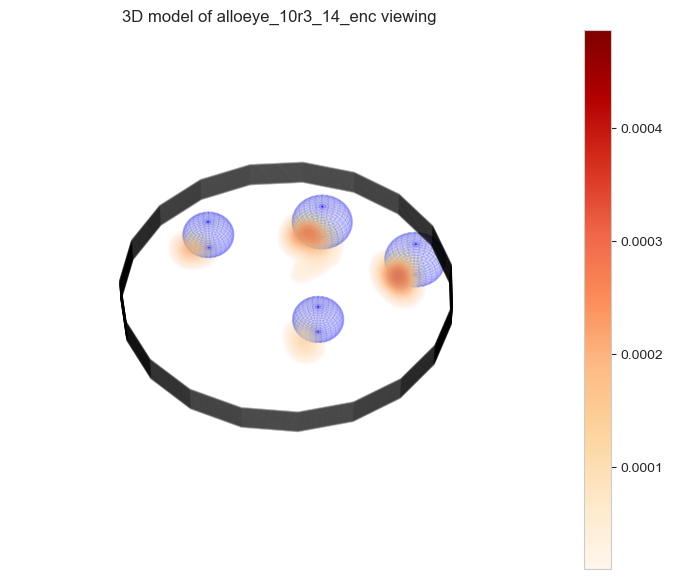

dataframe returned in 0.028922557830810547


C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19944\1069517913.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('OrRd')
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19944\1069517913.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable)


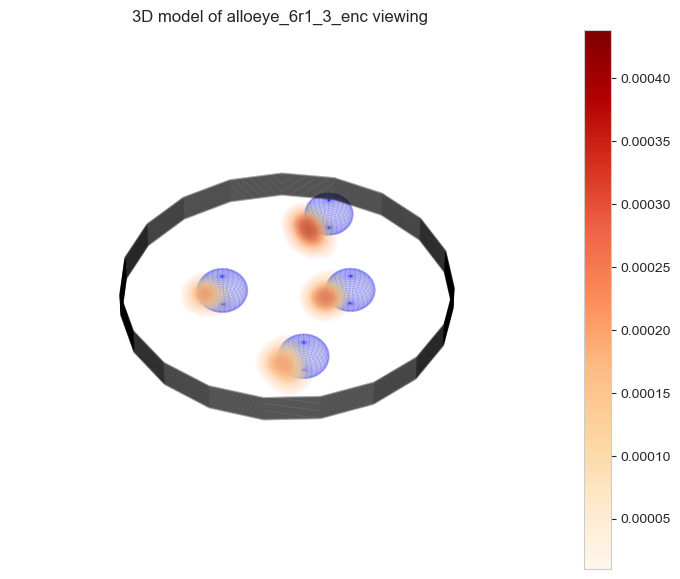

dataframe returned in 0.027924776077270508


C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19944\1069517913.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('OrRd')
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19944\1069517913.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable)


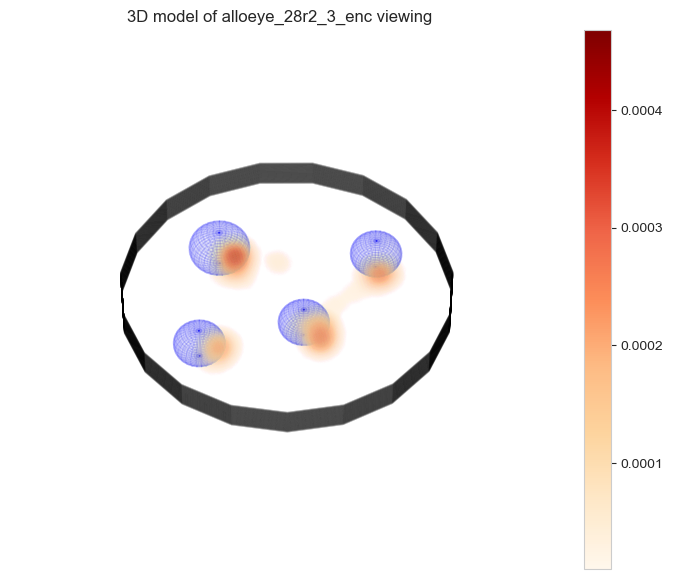

dataframe returned in 0.029919862747192383


C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19944\1069517913.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('OrRd')
C:\Users\Luke Emrich-Mills\AppData\Local\Temp\ipykernel_19944\1069517913.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mappable)


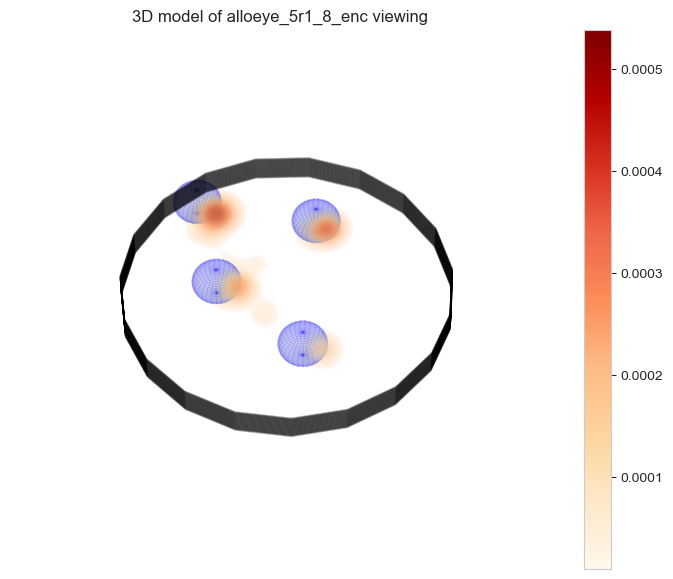

In [106]:
# assuming your data is in a variable called 'data'
# group_Ts_normed = group_data[0]
for c in range(len(Ts_normed)):
    data = Ts_normed[c]
    data = data.reshape(data.shape[0], data.shape[1], data.shape[2])
# print(data[:3, 0, :] )
# print(data.shape)
    prob_map, voxel_centers = create_3d_gaussian_prob_map(data, plot=False)
    pid = cluster_pids[c][0]
    tps = fetch_timepoints(pid, ret_epochs=['na'], configurations = [config], suppress_print=True)
    trial = all_trials[all_trials.trial_id == tps.trial_id[0]].reset_index(drop=True)
    viewing_plot(tps, trial=trial, preshift_postshift='preshift', prob_map=prob_map, pmap_voxel_centers=voxel_centers)
# prob_map = create_3d_probability_map(data, time_window_size=90, gaussian_sigma=5)

In [1]:
def split_data_by_group(Ts_normed, view, group):
    view_group_data = None
    # for each participant
    for p in range(Ts_normed[view].shape[2]):
        data = Ts_normed[view][:, :, p]
        # remove points out of bounds
        mask = (data[:, 0] >= min_x) & (data[:, 0] <= max_x) & \
               (data[:, 1] >= min_y) & (data[:, 1] <= max_y) & \
               (data[:, 2] >= min_z) & (data[:, 2] <= max_z)
        data = data[mask]
        data = data
        if cluster_pids[view][p] in pid_groups[group]:
            view_group_data = data if view_group_data is None else np.concatenate((view_group_data, data), axis=0)
            
    return view_group_data

(2109, 3)


C:\ProgramData\Anaconda3\envs\alloeye4\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(
C:\Users\Luke Emrich-Mills\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:219: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


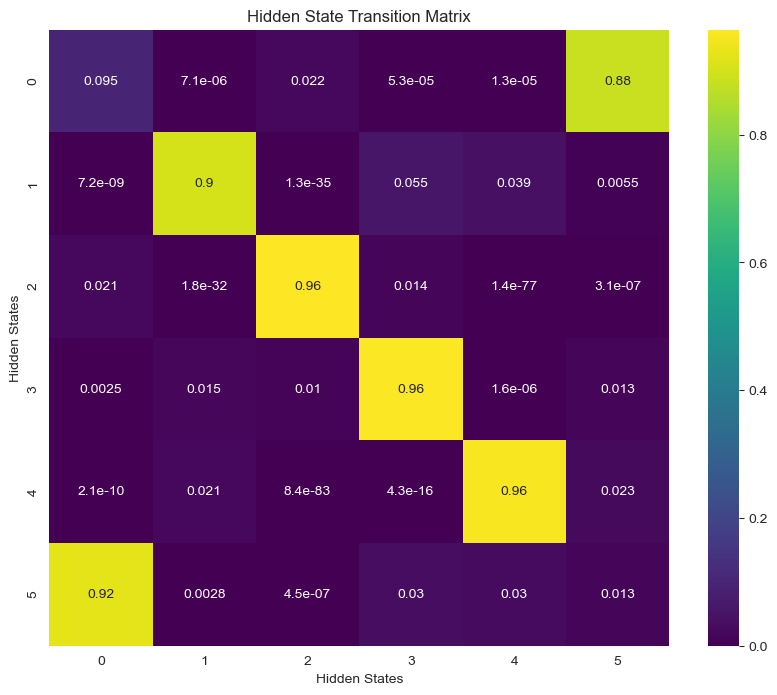

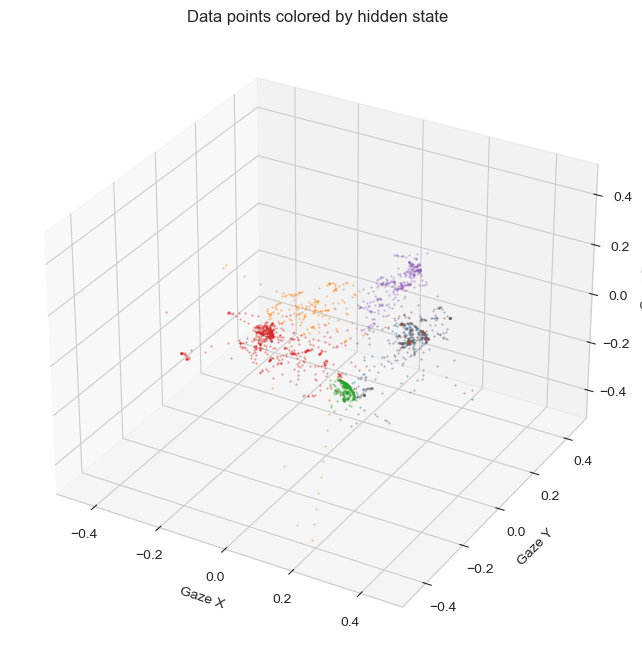

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


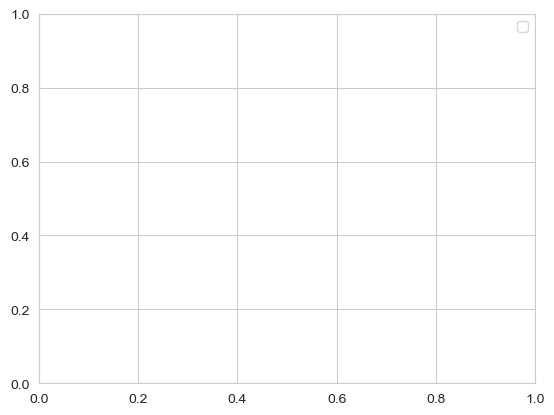

In [114]:
from hmmlearn import hmm
import seaborn as sns

view = 2  # first view
group = 1  # one group

bounds = 0.5
max_x, max_y, max_z = bounds, bounds, bounds
min_x, min_y, min_z = -bounds, -bounds, -bounds

view_group_data = split_data_by_group(Ts_normed, view, group)
print(view_group_data.shape)
# data = np.transpose(view_group_data, (0, 2, 1))  # change shape to (n_timepoints, n_participants, n_spatial_dimensions)
# X = data.reshape(-1, data.shape[-1])
X = view_group_data

# Initialize and train the HMM
model = hmm.GaussianHMM(n_components=6, covariance_type="full")
model.fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

# Visualize transitions between them using a heatmap for the transition matrix
plt.figure(figsize=(10, 8))
sns.heatmap(model.transmat_, annot=True, cmap='viridis')
plt.title('Hidden State Transition Matrix')
plt.xlabel('Hidden States')
plt.ylabel('Hidden States')
plt.show()

# # Reshape hidden states to match original data shape
# hidden_states_reshaped = hidden_states.reshape(data.shape[0], data.shape[1])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for s in np.unique(hidden_states):
    # Find where the hidden state is s
    indices = np.where(hidden_states == s)[0]
    ax.plot(X[indices, 0], X[indices, 2], X[indices, 1], '.', label=f'State {s}',  alpha=0.5, markersize=1)


# Calculate centroids of each state
centroids = np.array([X[hidden_states == s].mean(axis=0) for s in np.unique(hidden_states)])

# # Add centroids to the plot
# for s, centroid in enumerate(centroids):
#     ax.scatter(*centroid, s=1000, alpha=0.5, label=f'Centroid {s}')
#
# # Draw arrows (actually line segments) between centroids
# for (i, j), prob in np.ndenumerate(model.transmat_):
#     ax.quiver(centroids[i, 0], centroids[i, 2], centroids[i, 1],
#               (centroids[j, 0]-centroids[i, 0])*prob, (centroids[j, 2]-centroids[i, 2])*prob, (centroids[j, 1]-centroids[i, 1])*prob,
#               color='r', alpha=0.5, linewidth=1.5)
    # ax.text((centroids[i, 0] + centroids[j, 0])/2,
    #         (centroids[i, 1] + centroids[j, 1])/2,
    #         (centroids[i, 2] + centroids[j, 2])/2,
    #         f'p={prob:.2f}',
    #         color="r")

plt.title('Data points colored by hidden state')
ax.set_xlabel('Gaze X')
ax.set_ylabel('Gaze Y')
ax.set_zlabel('Gaze Z')
ax.set_xlim([-0.5, 0.5])
ax.set_zlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])
plt.show()
plt.legend()
plt.show()




In [86]:
model.transmat_

array([[1.98549636e-005, 3.16056720e-176, 1.40958285e-008,
        3.84454559e-003, 9.86382628e-001, 9.75295746e-003],
       [2.70799464e-160, 9.69972932e-001, 5.01360125e-004,
        1.51790148e-028, 5.67569021e-067, 2.95257082e-002],
       [7.41832186e-019, 1.11676350e-011, 9.63780656e-001,
        6.33328005e-004, 3.45148802e-003, 3.21345276e-002],
       [1.10968625e-004, 2.65959167e-031, 3.24051152e-003,
        9.56529875e-001, 3.30967615e-005, 4.00855481e-002],
       [9.22887425e-001, 2.85517870e-058, 8.11956753e-003,
        6.63242132e-004, 3.51655890e-002, 3.31641763e-002],
       [1.44487979e-002, 3.28075587e-002, 3.90148582e-002,
        1.68735132e-002, 9.36073974e-003, 8.87494532e-001]])

### Voxel-based analysis

In [ ]:
v = 0  # configuration view
g1 = 0  # first group - younger
g2 = 1  # second group - older

data1 = split_data_by_group(Ts_normed, v, g1)
data2 = split_data_by_group(Ts_normed, v, g2)

# might not be necessary after previous step
data1 = data1.reshape(data1.shape[0], data1.shape[1], data1.shape[2])
data2 = data2.reshape(data2.shape[0], data2.shape[1], data2.shape[2])


prob_map1, voxel_centers1 = create_3d_gaussian_prob_map(data1, plot=False)
prob_map2, voxel_centers2 = create_3d_gaussian_prob_map(data2, plot=False)

print('shapes match:', prob_map1.shape == prob_map2.shape)

In [ ]:
plot_lim = 3
plot_it = 0
for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        for k in range(data1.shape[2]):
            vox1 = data1[i, j, k]
            vox2 = data2[i, j, k]
            correlations[i, j, k] = np.corrcoef(vox1, vox2)[1, 0]
            if plot_it < plot_lim:
                ax = plt.figure().add_subplot()
                plt.plot(vox1, vox2, 'r.')
                plt.show()
                plot_it+=1


In [ ]:
pid = cluster_pids[v][0]
tps = fetch_timepoints(pid, ret_epochs=['na'], configurations = [config], suppress_print=True)
trial = all_trials[all_trials.trial_id == tps.trial_id[0]].reset_index(drop=True)
viewing_plot(tps, trial=trial, preshift_postshift='preshift', prob_map=correlations, pmap_voxel_centers=voxel_centers1, threshold=0)